# Evaluation of Surrogate Models

Currently we use `RandomForestRegressor(n_estimators=100)` to train a surrogate model mapping hyperparameters to performance.
Before training the performance is normalized s.t. the worst recorded performances on the task is 0, and the best recorded performance is 1.
For each task, we train a separate surrogate model.

A `Problem` object is created, which is a wrapper for a configuration that specifies which hyperparameters to model, and which experiment data or surrogate models to load.

In [1]:
import sys
sys.path.append("./src/")
from problem import Problem

problem = Problem("mlr_svm")

We first create a grid with surrogate responses for many configurations of `cost` and `gamma`:

In [3]:
import itertools
import numpy as np
import pandas as pd

min_c = problem.data.groupby(by='task_id')

costs = np.geomspace(problem.data.cost.min(), problem.data.cost.max(), 200)
gammas = np.geomspace(problem.data.gamma.min(), problem.data.gamma.max(), 200)
configurations = list(itertools.product(costs, gammas))
surrogate_response = pd.DataFrame(list(configurations), columns=['cost','gamma'])

In [4]:
for task, surrogate in problem.surrogates.items():
    scores = surrogate.predict(configurations)
    surrogate_response[task] = scores

In [5]:
surrogate_response["mean"] = surrogate_response.iloc[:, 2:].mean(axis=1)
surrogate_response["median"] = surrogate_response.iloc[:, 2:].median(axis=1)

In [6]:
surrogate_response

,cost,gamma,3893,3902,3903,3904,3907,3913,3917,3918,...,45,3560,3561,49,53,6,58,14954,mean,median
0,1.209920e-15,6.262440e-12,0.737437,0.636123,0.964960,0.374267,0.976864,0.380642,0.351622,0.445954,...,0.665893,0.510417,0.233432,0.054122,0.077754,0.250004,0.330905,0.213614,0.394369,0.338140
1,1.209920e-15,8.082234e-12,0.737437,0.636123,0.964960,0.374267,0.976864,0.380642,0.351622,0.445954,...,0.665893,0.510417,0.233432,0.054122,0.077754,0.250004,0.330905,0.213614,0.394369,0.338140
2,1.209920e-15,1.043084e-11,0.737437,0.636123,0.964960,0.374267,0.976864,0.380642,0.351622,0.445954,...,0.665893,0.510417,0.233432,0.054122,0.077754,0.250004,0.330905,0.213614,0.394369,0.338140
3,1.209920e-15,1.346193e-11,0.737437,0.636123,0.964960,0.374267,0.976864,0.380642,0.351622,0.445954,...,0.665893,0.510417,0.233432,0.054122,0.077754,0.250004,0.330905,0.213614,0.394369,0.338140
4,1.209920e-15,1.737381e-11,0.737437,0.636123,0.964960,0.374267,0.976864,0.380642,0.351622,0.445954,...,0.665893,0.510417,0.233432,0.054122,0.077754,0.250004,0.330905,0.213614,0.394369,0.338140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,1.129040e+10,2.514069e+10,0.000002,0.636635,0.996669,0.506477,0.999974,0.275781,0.387702,0.653483,...,0.201143,0.273411,0.222201,0.000000,0.045392,0.108461,0.023628,0.120485,0.283484,0.128956
39996,1.129040e+10,3.244629e+10,0.000002,0.636635,0.996669,0.506477,0.999974,0.275781,0.387702,0.653483,...,0.201143,0.273411,0.222201,0.000000,0.045392,0.108461,0.023628,0.120485,0.283484,0.128956
39997,1.129040e+10,4.187482e+10,0.000002,0.636635,0.996669,0.506477,0.999974,0.275781,0.387702,0.653483,...,0.201143,0.273411,0.222201,0.000000,0.045392,0.108461,0.023628,0.120485,0.283484,0.128956
39998,1.129040e+10,5.404317e+10,0.000002,0.636635,0.996669,0.506477,0.999974,0.275781,0.387702,0.653483,...,0.201143,0.273411,0.222201,0.000000,0.045392,0.108461,0.023628,0.120485,0.283484,0.128956


note not all experiment tasks seem to have meta-data yet:

In [7]:
set(problem.data.task_id.unique()) - set(problem.metadata.index)

{168759.0, 168761.0, 168770.0}

When we compare two configurations on their in-sample and out-of-sample performance, we would expect them to agree most of the times. We check this by:
 - drawing two configurations at random
 - compare the in-sample and out-of-sample configuration and note if they agree
 

In [8]:
def get_sample_scores(s, task):
    in_sample = np.mean(s[2:-2][s[2:-2].index != task])
    return s[task], in_sample
    
task_bool_pairs = list(itertools.product(problem.metadata.index,[True,  False]))
mi = pd.MultiIndex.from_tuples(task_bool_pairs, names=('task', ' '))
conf = pd.DataFrame(np.zeros((2*len(problem.metadata.index), 2)), columns=[True, False], index=mi)

for _ in range(100):
    samples = surrogate_response.sample(2)
    for task in problem.metadata.index:
        a_out, a_in = get_sample_scores(samples.iloc[0], task)
        b_out, b_in = get_sample_scores(samples.iloc[1], task)

        if a_out == b_out or a_in == b_in:
            continue
        conf.loc[(task, a_in > b_in)][a_out > b_out] += 1
    

In [9]:
acc = pd.DataFrame([[0]] * len(problem.metadata.index), columns=["accuracy"], index=problem.metadata.index)

for task in problem.metadata.index:
    c = conf.loc[task]
    acc.loc[task] = (c.loc[True, True] + c.loc[False, False]) / c.sum().sum()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026F32470668>]],
      dtype=object)

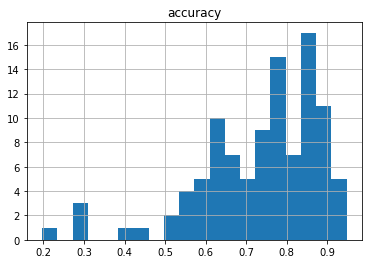

In [10]:
acc.hist(bins=20)

In [11]:
print(f"mean: {acc.mean().values[0]:.3f}, median: {acc.median().values[0]:.3f}")

mean: 0.733, median: 0.770


To me, it seems that for static configurations the surrogate models behave as expected. Not perfect, but likely good enough. The big difference here is that we compared static configurations. We will now try this comparison with some dynamic configurations (takes more time):

In [12]:
def sklearn(row):
    return np.asarray([1., 1. / (row.p * row.xvar)]).reshape(1, -1)

def symbolic1(row):
    return np.asarray([16., row.mkd / row.xvar]).reshape(1, -1)

def symbolic2(row):
    return np.asarray([row.m, row.mkd + row.mkd]).reshape(1, -1)

def constant(row):
    return np.asarray([812.267350, 0.001361]).reshape(1, -1)

dynamic_defaults = [sklearn, symbolic1, symbolic2, constant]

The following code is un-optimized. This is deliberate, to make it easier to check for correctness.
We create a dataframe with for each task a row, and for each dynamic default a column. 
In each cell we note the predicted performance of the dynamic configuration.

In [13]:
dd_names = list(map(lambda x:x.__name__, dynamic_defaults))
out_sample = pd.DataFrame([[0.] * 4] * len(problem.metadata.index), columns=dd_names, index=problem.metadata.index)

In [14]:
for task, metadata in problem.metadata.iterrows():
    for name, fn in zip(dd_names, dynamic_defaults):
        out_sample.loc[task][name] = problem.surrogates[task].predict(fn(metadata))

In [15]:
out_sample

,sklearn,symbolic1,symbolic2,constant
3,0.921743,0.980686,0.876921,0.942129
6,0.968598,0.988993,0.996004,0.926806
11,0.883043,0.952532,0.904208,0.896596
12,0.992578,0.998448,0.995730,0.998270
14,0.964482,0.996041,0.987067,0.993019
...,...,...,...,...
189924,0.766128,0.986726,0.521526,0.557975
189927,0.971395,0.972945,0.887940,0.935110
189928,0.888723,0.977982,0.885039,0.836121
190411,0.871535,0.929714,0.885429,0.888776


Counting the best dynamic default for each task (based on the "true" performance predicted by the surrogates):

In [16]:
out_sample.idxmax(axis=1).value_counts()

symbolic1    44
symbolic2    21
constant     20
sklearn      18
dtype: int64

It looks like the best overall dynamic default is `symbolic1`, though it certainly varies per task.
Let's see what the in-sample surrogates would predict.

In [17]:
in_sample = pd.DataFrame([[0.] * 4] * len(problem.metadata.index), columns=dd_names, index=problem.metadata.index)

In [18]:
for task, metadata in problem.metadata.iterrows():
    for name, fn in zip(dd_names, dynamic_defaults):
        # take the mean of the predicted performance on all tasks but 'task' for the given dynamic default:
        in_sample.loc[task][name] = out_sample[out_sample.index != task][name].mean()

In [19]:
in_sample

,sklearn,symbolic1,symbolic2,constant
3,0.883735,0.894451,0.884096,0.857473
6,0.883276,0.894370,0.882929,0.857623
11,0.884115,0.894727,0.883829,0.857919
12,0.883041,0.894277,0.882931,0.856922
14,0.883316,0.894301,0.883016,0.856974
...,...,...,...,...
189924,0.885261,0.894392,0.887581,0.861239
189927,0.883248,0.894527,0.883988,0.857542
189928,0.884059,0.894478,0.884017,0.858512
190411,0.884227,0.894951,0.884013,0.857996


In [20]:
in_sample.idxmax(axis=1).value_counts()

symbolic1    103
dtype: int64

Symbolic1 completely dominates the in-sample ranking. It was picked based on the average response surface of surrogate models, so that's not really a surprise. On the other hand it is surprising since before we observed that for constant configurations in and out sample seem to largely agree.

In [21]:
correct = []
for name1, name2 in itertools.combinations(dd_names, 2):
    for task in problem.metadata.index:
        a_in = in_sample.loc[task][name1]
        b_in = in_sample.loc[task][name2]
        b_out = out_sample.loc[task][name2]
        a_out = out_sample.loc[task][name1]
        correct.append((a_in > b_in and a_out > b_out) or (a_in <= b_in and a_out <= b_out))

In [22]:
sum(correct)/ len(correct)

0.551779935275081

One difference is that for constants, we had many different samples drawn, so let's draw four constant configurations and compare them in the same way we did dynamic ones:

In [100]:
samples = surrogate_response.sample(4)
out_sample_const = pd.DataFrame([[0.] * 4] * len(problem.metadata.index), columns=[0, 1, 2, 3], index=problem.metadata.index)
in_sample_const = pd.DataFrame([[0.] * 4] * len(problem.metadata.index), columns=[0, 1, 2, 3], index=problem.metadata.index)

In [101]:
for task, metadata in problem.metadata.iterrows():
    for i, (idx, sample) in enumerate(samples.iterrows()):
        out_sample_const.loc[task][i] = sample[task]
        in_sample_const.loc[task][i] = sample.iloc[2:-2][sample.iloc[2:-2].index != task].mean()

In [102]:
correct = []
for c1, c2 in itertools.combinations(range(4), 2):
    for task in problem.metadata.index:
        a_in = in_sample_const.loc[task][c1]
        b_in = in_sample_const.loc[task][c2]
        b_out = out_sample_const.loc[task][c2]
        a_out = out_sample_const.loc[task][c1]
        correct.append((a_in > b_in and a_out > b_out) or (a_in <= b_in and a_out <= b_out))

In [103]:
sum(correct)/ len(correct)

0.8446601941747572

Quick to rerun, results vary from 0.58 (similar to dynamic

---- 
**ignore below**

We can now calculate for each task gamma/cost based on a formula, and evaluate if evalution code is correct.
Can also draw two random configurations and see if order holds.

In [ ]:
def get_sample_scores(s, task):
    in_sample = np.mean(s[2:-2][s[2:-2].index != task])
    return s[task], in_sample
    
task_bool_pairs = list(itertools.product(problem.metadata.index,[True,  False]))
mi = pd.MultiIndex.from_tuples(task_bool_pairs, names=('task', ' '))
conf = pd.DataFrame(np.zeros((2*len(problem.metadata.index), 2)), columns=[True, False], index=mi)

for _ in range(1000):
    samples = surrogate_response.sample(2)
    for task in problem.metadata.index:
        a_out, a_in = get_sample_scores(samples.iloc[0], task)
        b_out, b_in = get_sample_scores(samples.iloc[1], task)

        if a_out == b_out or a_in == b_in:
            continue
        conf.loc[(task, a_in > b_in)][a_out > b_out] += 1
            
    

In [ ]:
conf

In [ ]:
def get_sample_scores(s, task):
    in_sample = np.mean(s[2:-2][s[2:-2].index != task])
    return s[task], in_sample
    
agreed=0
for _ in range(1000):
    samples = surrogate_response.sample(2)
    a_in_outs = [get_sample_scores(samples.iloc[0], task) for task in problem.metadata.index]
    b_in_outs = [get_sample_scores(samples.iloc[1], task) for task in problem.metadata.index]
    a_outs, a_ins = list(zip(*a_in_outs))
    b_outs, b_ins = list(zip(*b_in_outs))
    a_in_wins = sum([a_in > b_in for (a_in, b_in) in zip(a_ins, b_ins)])
    b_in_wins = sum([b_in > a_in for (a_in, b_in) in zip(a_ins, b_ins)])
    a_out_wins = sum([a_in > b_in for (a_in, b_in) in zip(a_outs, b_outs)])
    b_out_wins = sum([b_in > a_in for (a_in, b_in) in zip(a_outs, b_outs)])
    if ((a_in_wins > b_in_wins and a_out_wins > b_out_wins)
        or (b_in_wins > a_in_wins and b_out_wins > a_out_wins)):
        agreed += 1
agreed
        
    
#     for task in problem.metadata.index:
#         a_out, a_in = 
#         b_out, b_in = get_sample_scores(samples.iloc[1], task)

#         if a_out == b_out or a_in == b_in:
#             continue
#         conf.loc[(task, a_in > b_in)][a_out > b_out] += 1
            

In [ ]:
conf.loc[9971]

In [ ]:
task_acc = []
for task in problem.metadata.index:
    c = conf.loc[task]
    task_acc.append(((c.loc[True, True] + c.loc[False, False]) / c.sum().sum(), task))


In [ ]:
problem.metadata.index

In [ ]:
print(sorted(task_acc))

In [ ]:
task_acc = []
for task in problem.metadata.index:
    c = conf.loc[task]
    task_acc.append(((c.loc[True, True] + c.loc[False, False]) / c.sum().sum(), task))


In [ ]:
costs = [1] * len(problem.metadata)
gammas = 1. / (problem.metadata.p * problem.metadata.xvar)
si = surrogate_response.set_index(['cost', 'gamma'])

In [ ]:
si.index.get_loc((costs[0], gammas.iloc[0]), method='nearest')

In [ ]:
surrogate_pivot = surrogate_response.pivot("cost", "gamma", "mean")
sns.heatmap(surrogate_pivot)

In [ ]:
nrows, ncolumns = 11, 10
f, axes = plt.subplots(nrows, ncolumns, figsize=(100, 100))
for i, task in enumerate(surrogate_response.columns[2:]):
    ax = axes[i // ncolumns, i % ncolumns]
    surrogate_pivot = surrogate_response.pivot("cost", "gamma", task)
    sns.heatmap(surrogate_pivot, ax=ax)
    ax.set(title=task);
    print(i)


In [ ]:
f.savefig("test.png")

In [ ]:
# Zoomed in:
costs = np.geomspace(7e2, 1e3, 200)
gammas = np.geomspace(1e-4, 1e-2, 200)
configurations = list(itertools.product(costs, gammas))
surrogate_scores = pd.DataFrame(list(configurations), columns=['cost','gamma'])

for task, surrogate in problem.surrogates.items():
    scores = surrogate.predict(configurations)
    surrogate_scores[task] = scores
    
surrogate_scores["mean"] = surrogate_scores.iloc[:, 2:].mean(axis=1)

surrogate_pivot = surrogate_scores.pivot("cost", "gamma", "mean")
sns.heatmap(surrogate_pivot)

In [ ]:
# Warp with metafeatures m, mkd
costs =  np.geomspace(6e-2, 100, 200)
gammas = np.geomspace(1e-1, 12, 200)
configurations = list(itertools.product(costs, gammas))
surrogate_scores = pd.DataFrame(list(configurations), columns=['cost','gamma'])


for task, surrogate in problem.surrogates.items():
    if (task in problem.metadata.index):
        cfgs = list(itertools.product(costs * problem.metadata.loc[task, "m"], gammas * problem.metadata.loc[task,"mkd"]))
        scores = surrogate.predict(cfgs)
        surrogate_scores[task] = scores
        
surrogate_scores["mean"] = surrogate_scores.iloc[:, 2:].mean(axis=1)

surrogate_pivot = surrogate_scores.pivot("cost", "gamma", "mean")
sns.heatmap(surrogate_pivot)

In [ ]:
# Warp with metafeatures 1 / (p*xvar)
costs =  np.geomspace(6e-2, 100, 200)
gammas = np.geomspace(1e-1, 12, 200)
configurations = list(itertools.product(costs, gammas))
surrogate_scores = pd.DataFrame(list(configurations), columns=['cost','gamma'])


for task, surrogate in problem.surrogates.items():
    if (task in problem.metadata.index):
        cfgs = list(itertools.product(costs, gammas * (1 / problem.metadata.loc[task,"p"] / problem.metadata.loc[task,"xvar"])))
        scores = surrogate.predict(cfgs)
        surrogate_scores[task] = scores
        
surrogate_scores["mean"] = surrogate_scores.iloc[:, 2:].mean(axis=1)

surrogate_pivot = surrogate_scores.pivot("cost", "gamma", "mean")
sns.heatmap(surrogate_pivot)

In [ ]:
# List of settings:
d0 = surrogate_scores.loc[surrogate_scores["mean"] == max(surrogate_scores["mean"])]

In [ ]:
best_idx = 0
best = 0
for idx, row in surrogate_scores.iterrows():
    newmax = np.mean(np.maximum(row.iloc[2:-1].values, d0.iloc[:,2:-1].values))
    if (newmax > best):
        print(f"Newmax found: {newmax}")
        best = newmax
        best_idx = idx

surrogate_scores.iloc[best_idx,:]